# Using Natural Language Processing to predict suicidal ideation on Reddit

## Setup

In [1]:
## Uncomment if using google colab 
%%capture
from google.colab import drive
drive.mount('/content/drive')     # connect to google drive

!cp /content/drive/MyDrive/Colab\ Notebooks/utils.py /content/    # import utils.py to the working folder
!cp /content/drive/MyDrive/Colab\ Notebooks/Suicide_Detection.csv /content/   # import data to the working folder

!pip install contractions
!pip install langdetect
!python -m spacy download en_core_web_lg

In [2]:
# Import libraries and helper functions
import warnings
warnings.filterwarnings('ignore')
from utils import *

In [3]:
# Read in data
# data_path = "~/Desktop/Work/Github/_data/Suicide_Detection.csv"  # comment if using google colab
data_path = "/content/Suicide_Detection.csv"      # uncomment if using google colab
reddit_data = pd.read_csv(data_path, index_col = 0).reset_index(drop=True)
reddit_data.sample(5, random_state= 1)  # peak at a random sample of 5 rows

,text,class
79689,I want to go to sleep and never wake upMy reas...,suicide
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide
226306,the sun is setting and it's raining i'm curren...,non-suicide
101296,Hi. Im scared. Plz talk to me.Private message,suicide
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide


In [4]:
# Look into the data
reddit_data.info()      # data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


The dataset has two columns, both in correct data types and there are no missing values. There is a total of 232,074 observations (rows)

## Initial Text Analysis

### Distribution of target variable classes

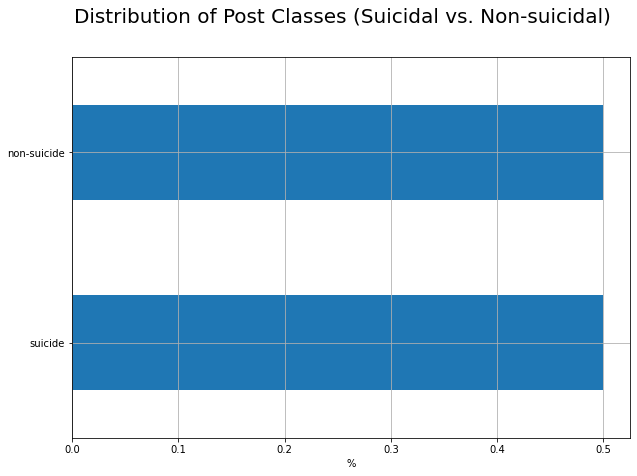

In [5]:
# Evaluate distribution of post classes (target variable)
plot_distributions(data=reddit_data, x="class", figsize=(10,7), title= "Distribution of Post Classes (Suicidal vs. Non-suicidal)", 
                    xlabel="%", normalize=True)

The target variable is perfectly balanced, meaning 50% are suicidal posts while the other half is not. 

In [6]:
# Uncomment below to run only 1% of the data (~2K observations)
# reddit_data = reddit_data.sample(frac=0.01, random_state=1)

### Extract more text characteristics
Features to be extracted from each post (processed text): 
- Number of words
- Number of characters
- Number of sentences
- Average word length
- Average sentence length

In [7]:
# Uncomment if using google colab
nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
reddit_data = extract_lengths(data=reddit_data, col="text")

  0%|          | 0/232074 [00:00<?, ?it/s]

  0%|          | 0/232074 [00:00<?, ?it/s]

  0%|          | 0/232074 [00:00<?, ?it/s]

Characteristics of text:

                min        mean      max
char_count      3.0  555.773327  40086.0
word_count      1.0  154.649918  23373.0
sentence_count  1.0    8.323875   8209.0
avg_word_len    1.0    4.019507  11100.0
avg_sent_len    1.0   23.737441  16203.0


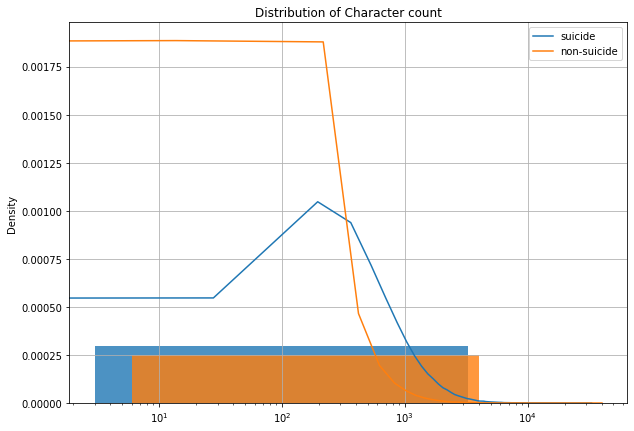

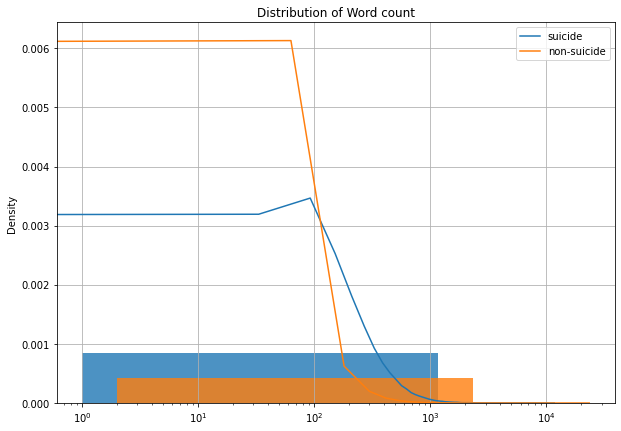

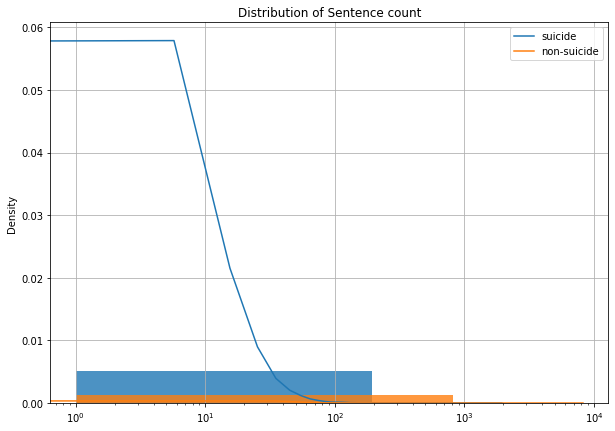

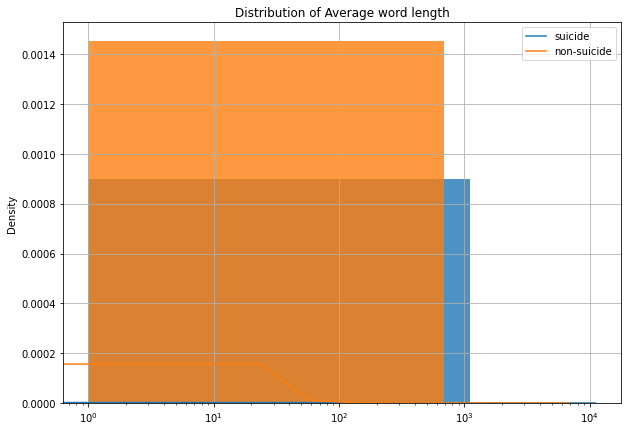

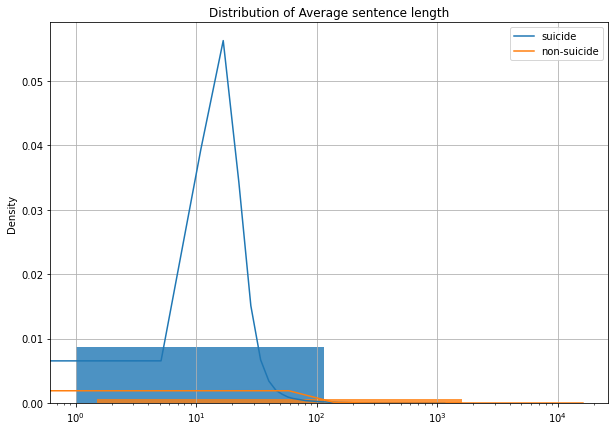

In [9]:
columns = {"char_count": "Character count","word_count": "Word count","sentence_count": "Sentence count","avg_word_len": "Average word length","avg_sent_len": "Average sentence length"}

# for col in ["char_count","word_count","sentence_count","avg_word_len","avg_sent_len"]:
#     plot_distributions(reddit_data, x=col, y="class", bins=10, figsize=(10,7), title= f"Distribution of {col}")

for key, value in columns.items():
    plot_distributions(reddit_data, x=key, y="class", bins=10, figsize=(10,7), title= f"Distribution of {value}", xlog = True)

Overall, the number of characters and words in the suicidal posts tends to be higher than that in non-suicidal posts. However, the average number of words and sentences is the fairly similar between the two groups

## Text cleaning

### Remove punctuations, URLs, stopwords, and lowercase the posts

In [10]:
stopwords = stopwords_list(add_words= ["fill", "filler", "reddit"])        # use default NLTK english stopwords
reddit_data = append_clean_text(reddit_data, column="text", stopwords=stopwords)

  0%|          | 0/232074 [00:00<?, ?it/s]

  0%|          | 0/232074 [00:00<?, ?it/s]

--- found NAs ---
                                                    text text_clean
408    ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎  ︎\n︎\...           
5047   whhduduehdhttps://wad.ojooo.com/register.php?r...           
9592   ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏͏͏͏ ͏ ͏ ͏ ͏...           
11476  Me when the💕💕 ​​​​​ ​​​​​​ ​​​​​​ ​​​​​​​​ ​​​...           
12847     I’m so S̸̢̟̝͎̟̘̽̂̆̅̀́̈́́͜͝á̴̡̮͕͕̙̩d̸̨͙̱̙͚͛̓̍̆ͅ           


In [11]:
reddit_data.head()

,text,class,word_count,char_count,sentence_count,avg_word_len,avg_sent_len,text_clean
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,156,573,7,3.673077,22.285714,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,29,112,1,3.862069,29.000000,weird get affected compliments coming someone ...
2,Finally 2020 is almost over... So I can never ...,non-suicide,31,106,3,3.419355,10.333333,finally almost never hear bad year ever swear ...
3,i need helpjust help me im crying so hard,suicide,9,33,1,3.666667,9.000000,need helpjust help crying hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,524,1985,21,3.788168,24.952381,losthello name adam struggling years afraid pa...


### Sentiment Analysis

In [12]:
# use textblob to find sentiment for each post 
reddit_data = add_sentiment(reddit_data, "text_clean", algo="textblob", sentiment_range=(-1,1)) # sentiment for a range of -1 to 1
reddit_data.head()

  0%|          | 0/231999 [00:00<?, ?it/s]

              count     mean       std  min  25%  50%       75%  max
sentiment  231999.0  0.01808  0.248011 -1.0 -0.1  0.0  0.137655  1.0


,text,class,word_count,char_count,sentence_count,avg_word_len,avg_sent_len,text_clean,sentiment
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,156,573,7,3.673077,22.285714,ex wife threatening suiciderecently left wife ...,0.116667
1,Am I weird I don't get affected by compliments...,non-suicide,29,112,1,3.862069,29.000000,weird get affected compliments coming someone ...,0.100000
2,Finally 2020 is almost over... So I can never ...,non-suicide,31,106,3,3.419355,10.333333,finally almost never hear bad year ever swear ...,-0.525000
3,i need helpjust help me im crying so hard,suicide,9,33,1,3.666667,9.000000,need helpjust help crying hard,-0.245833
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,524,1985,21,3.788168,24.952381,losthello name adam struggling years afraid pa...,-0.209650


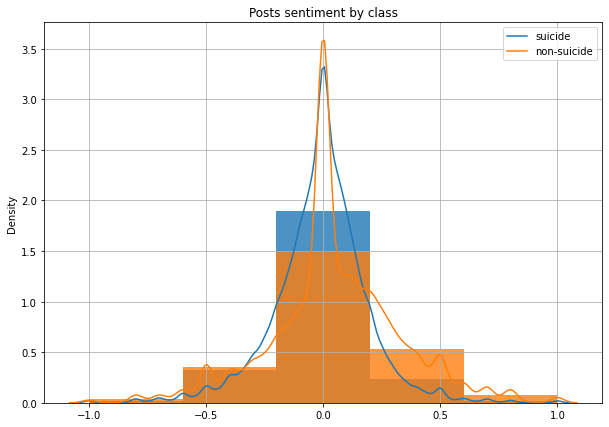

In [13]:
## Visualize sentiment 
plot_distributions(reddit_data, x="sentiment", y="class", bins=5, figsize=(10,7), title= "Posts sentiment by class")

The sentiment for both suicidal and non-suicidal posts are normally distributed and overlap. There seem to be no significant difference in the sentiment between posts. 


# suicide:


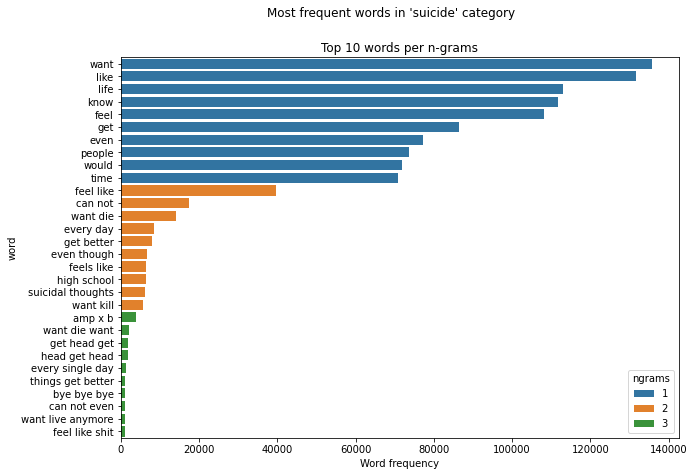

# non-suicide:


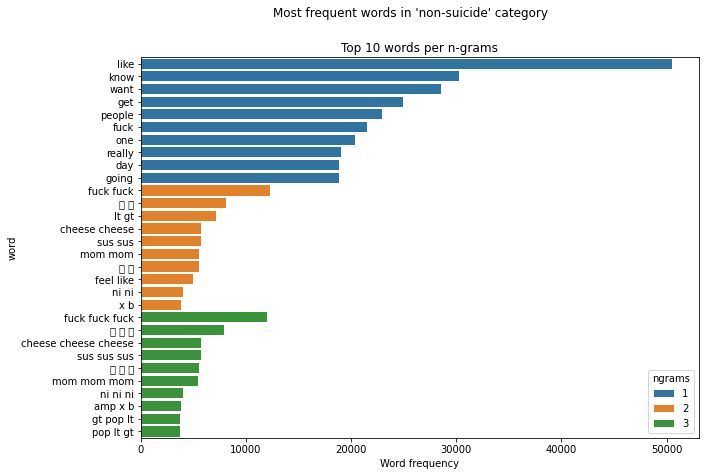

In [14]:
## Investigate the most frequent n-grams (up to 3) in clean text

dtf_freq = pd.DataFrame()
for y in reddit_data["class"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=reddit_data[reddit_data["class"]==y]["text_clean"], ngrams=[1,2,3], top=10, figsize=(10,7), title = f"Most frequent words in '{y}' category")
    dtf_y["class"] = y
    dtf_freq = dtf_freq.append(dtf_y)

more negative words in suicide (cannot, not) and more feeling words (feel, want, die)

# suicide:


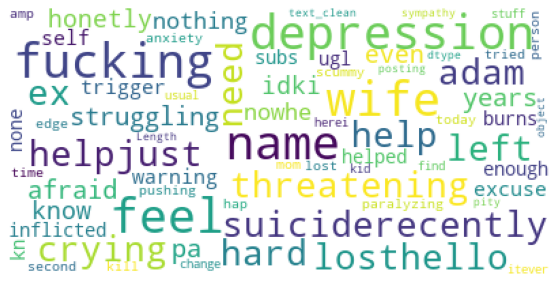

# non-suicide:


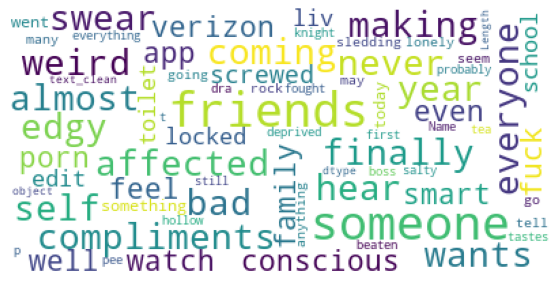

In [15]:
for y in reddit_data["class"].unique():
    print(f"# {y}:")
    plot_wordcloud(corpus=reddit_data[reddit_data["class"]==y]["text_clean"], max_words=150, max_font_size=35, figsize=(10,5))

### Export data


In [17]:
reddit_data.to_csv('/content/clean_reddit.csv', index = False)
reddit_data.to_csv('/content/drive/MyDrive/Colab Notebooks/clean_reddit.csv', index = False)